In [1]:
import tensorflow as tf
import os

2025-10-17 05:56:24.909677: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-17 05:56:25.763717: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-17 05:56:28.296274: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')

In [3]:
len(gpus)

1

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
import cv2
import imghdr
from matplotlib import pyplot as plt

/tmp/ipykernel_832/3427753027.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [6]:
data_dir = 'data'

In [7]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [8]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            

In [9]:
import numpy as np

In [10]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 275 files belonging to 2 classes.


I0000 00:00:1760680592.117841     832 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9515 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


In [11]:
data_iterator = data.as_numpy_iterator()

In [12]:
batch = data_iterator.next()

In [13]:
# Class 1 = Dog
# Class 2 = Cat

batch[0].shape

(32, 256, 256, 3)

In [14]:
batch[1]

array([1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 1], dtype=int32)

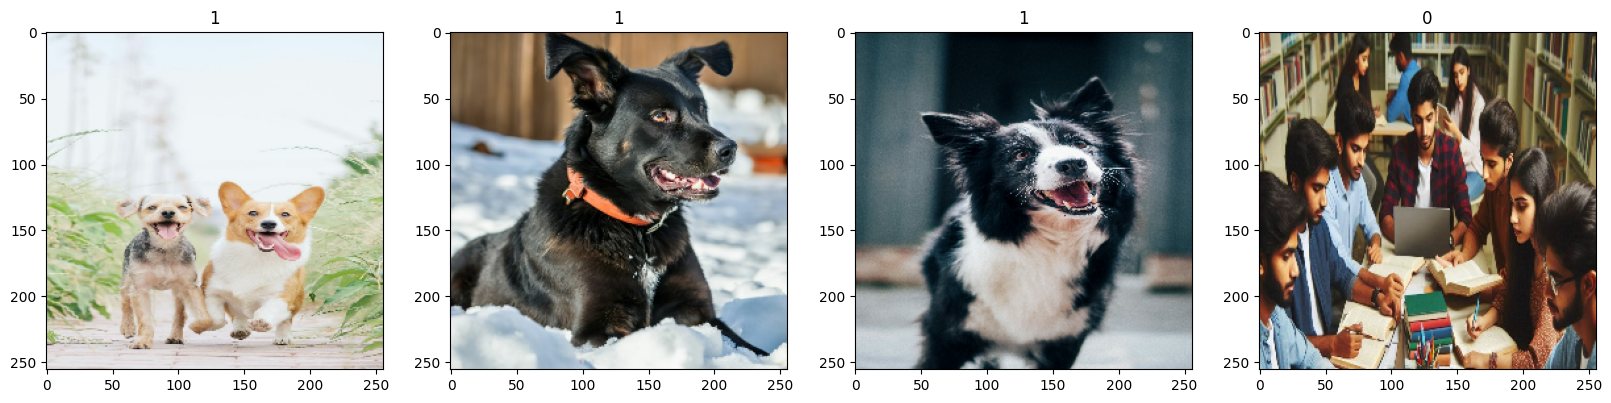

In [15]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [16]:
scaled = batch[0] / 255

In [17]:
scaled.max()

np.float32(1.0)

In [18]:
data = data.map(lambda x,y: (x/255, y))

In [19]:
scaled_iterator = data.as_numpy_iterator()

In [20]:
batch = scaled_iterator.next()

In [21]:
batch[0].max()

np.float32(1.0)

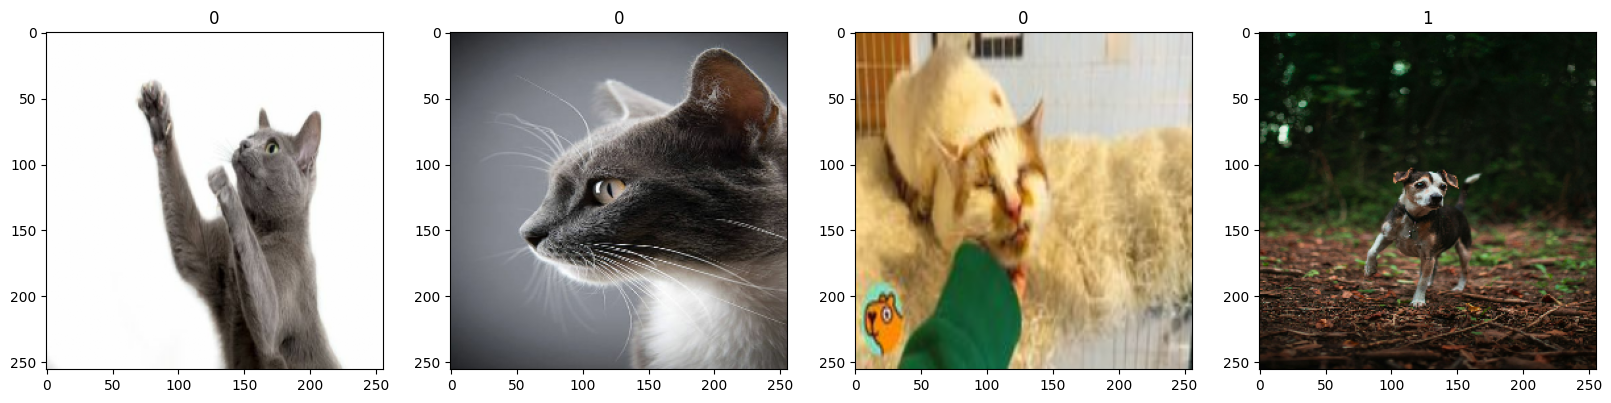

In [22]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [23]:
len(data)

9

In [24]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [25]:
test_size+train_size+val_size

9

In [26]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

len(test)

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [28]:
model = Sequential()

In [29]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

/home/dastr/Cod/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
logdir = 'logs'

In [33]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [34]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


2025-10-17 05:56:35.831592: I external/local_xla/xla/service/service.cc:163] XLA service 0x74be6c2089a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-17 05:56:35.831649: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 SUPER, Compute Capability 8.9
2025-10-17 05:56:35.926505: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-17 05:56:36.429496: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91301
2025-10-17 05:56:36.477089: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-17 05:56:36.94449

5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4606 - loss: 0.9779

I0000 00:00:1760680599.581356    1080 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - accuracy: 0.4167 - loss: 1.0034 - val_accuracy: 0.5000 - val_loss: 0.6939
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5990 - loss: 0.6707 - val_accuracy: 0.8281 - val_loss: 0.6275
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7760 - loss: 0.6036 - val_accuracy: 0.7188 - val_loss: 0.5384
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7656 - loss: 0.5235 - val_accuracy: 0.7812 - val_loss: 0.4776
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7812 - loss: 0.4664 - val_accuracy: 0.7969 - val_loss: 0.4411
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8229 - loss: 0.3995 - val_accuracy: 0.9219 - val_loss: 0.3111
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8802 - loss: 0.3146 - val_accuracy: 0.9375 - val_loss: 0.2625
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9010 - loss: 0.2477 - val_accuracy: 1.0000 - val_loss: 0.1773
Epoch 9/20

In [35]:
hist.history

{'accuracy': [0.4166666567325592,
  0.5989583134651184,
  0.7760416865348816,
  0.765625,
  0.78125,
  0.8229166865348816,
  0.8802083134651184,
  0.9010416865348816,
  0.9479166865348816,
  0.96875,
  0.9427083134651184,
  0.9583333134651184,
  0.984375,
  0.9947916865348816,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'loss': [1.0033568143844604,
  0.6706807613372803,
  0.603647768497467,
  0.5235195755958557,
  0.4663751423358917,
  0.39949831366539,
  0.314635306596756,
  0.24765241146087646,
  0.16866113245487213,
  0.12593956291675568,
  0.13589228689670563,
  0.12237580865621567,
  0.07928848266601562,
  0.038780659437179565,
  0.022792113944888115,
  0.019541703164577484,
  0.008716098964214325,
  0.006915796082466841,
  0.008240153081715107,
  0.004880466032773256],
 'val_accuracy': [0.5,
  0.828125,
  0.71875,
  0.78125,
  0.796875,
  0.921875,
  0.9375,
  1.0,
  1.0,
  0.96875,
  0.96875,
  1.0,
  0.984375,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'val_loss': [0.69

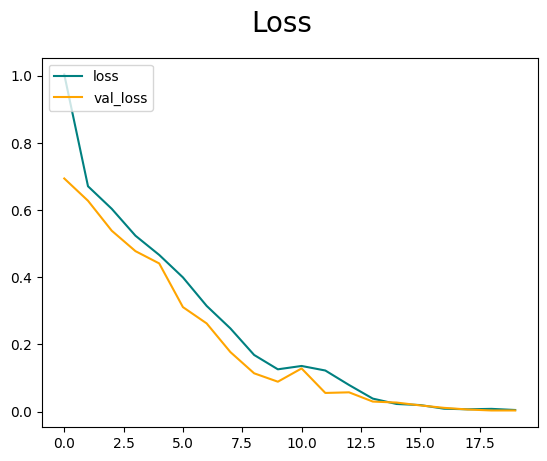

In [36]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

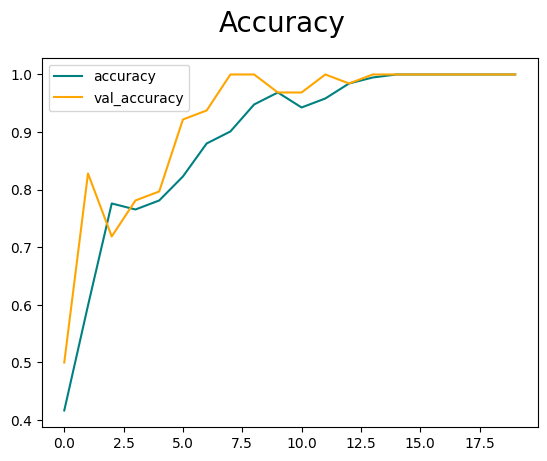

In [37]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [38]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [39]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [40]:
len(test)    

1

In [41]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step


2025-10-17 05:56:49.358154: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [42]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:1.0, Recall:1.0, Accuracy:1.0


In [43]:
import cv2

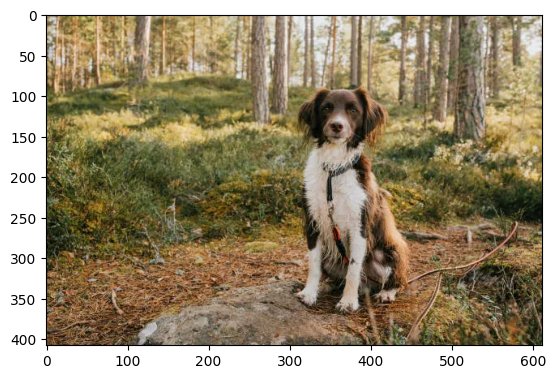

In [44]:
img = cv2.imread('dogtest.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

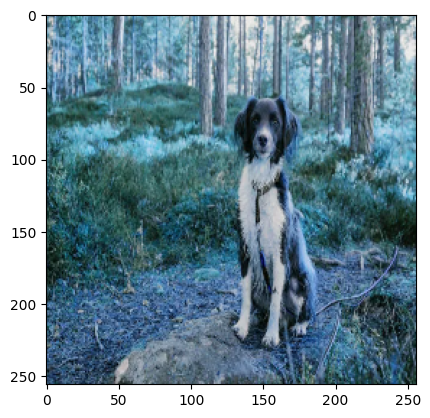

In [45]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()


In [46]:
resize.shape

TensorShape([256, 256, 3])

In [47]:
np.expand_dims(resize, 0).shape

(1, 256, 256, 3)

In [48]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


In [49]:
yhat

array([[0.9978873]], dtype=float32)

In [50]:
if yhat > 0.5:
    print(f'Predicted class is Dog')
else:
    print(f'Predicted class is Cat')

Predicted class is Dog


In [51]:
from tensorflow.keras.models import load_model

In [52]:
model.save(os.path.join('models','dogcatmodel.h5'))

In [53]:
os.path.join('models','dogcatmodel.h5')

'models/dogcatmodel.h5'

In [54]:
new_model = load_model(os.path.join('models','dogcatmodel.h5'))

In [55]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


array([[0.9978873]], dtype=float32)

In [56]:
yhatnew = new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [57]:
if yhat > 0.5:
    print(f'Predicted class is Dog')
else:
    print(f'Predicted class is Cat')

Predicted class is Dog


In [58]:
import sys
print(sys.executable)

/home/dastr/Cod/myenv/bin/python
